# Quick Tutorial
This is a short, straightforward tutorial for generating your first waveform with `bhpwave`.

First from the `bhpwave` package and its `waveform` module, load the waveform generator `KerrWaveform`

In [1]:
from bhpwave.waveform import KerrWaveform

Next define a set of paramters for evaluating your waveform

In [2]:
M = 1e6  # primary mass in solar masses
mu = 3e1 # secondary mass in solar masses
a = 0.9 # dimensionless spin of the primary
p0 = 6.55 # initial semi-latus rectum
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal sky angle
dist = 2.0  # distance to source in Gpc
Phi_phi0 = 0.2 # initial azimuthal position of the secondary
Phi_theta0 = 0.0 # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits
dt = 10.0  # time steps in seconds
T = 1.0  # waveform duration in years

injection_paramters = [M, mu, a, p0, e0, x0, 
                       dist, qK, phiK, qS, phiS, 
                       Phi_phi0, Phi_theta0, Phi_r0, 
                       dt, T]

Then load an instance of the waveform generator class

In [3]:
kerr_gen = KerrWaveform()

And generate a signal!

In [4]:
h = kerr_gen(*injection_paramters)

We can inspect our signal by plotting the signal over the entire observation

In [5]:
import matplotlib.pyplot as plt
import numpy as np

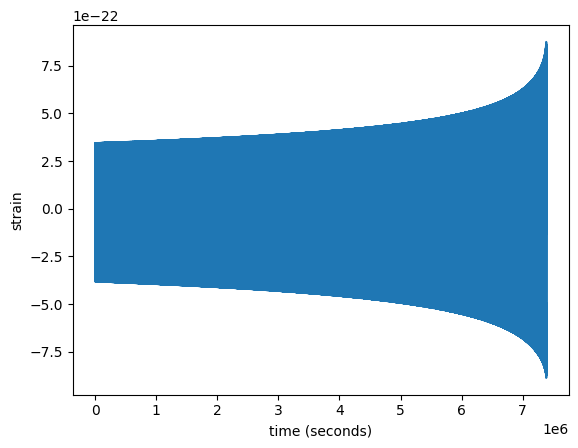

In [6]:
t = np.arange(h.shape[0])*dt
plt.plot(t, h.real)
plt.xlabel("time (seconds)")
plt.ylabel("strain")
plt.show()

Or by looking at the behavior of the different polarizations over a short time segment

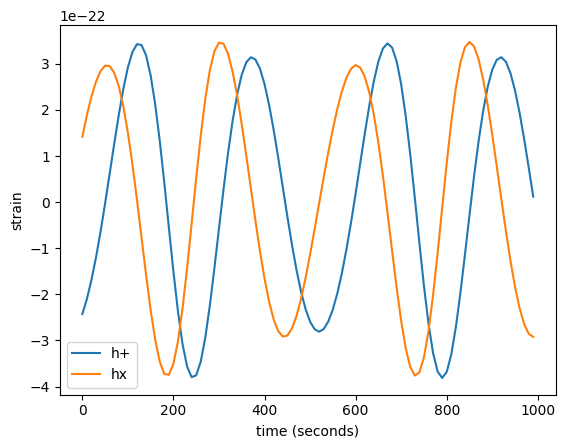

In [7]:
plt.plot(t[:100], h.real[:100], label="h+")
plt.plot(t[:100], -h.imag[:100], label="hx")
plt.xlabel("time (seconds)")
plt.ylabel("strain")
plt.legend()
plt.show()